<pre><font size=6>Spoken Digit Recognition</font></pre>
<pre>
In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number

It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

<font size=5>Instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List of we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>

</pre>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<pre><font size=4> Importing Libraries </font></pre> 

In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import glob
from joblib import Parallel, delayed
import time
import librosa.display
from collections import Counter
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, LSTM, Dense, AveragePooling2D, GlobalAveragePooling2D, AveragePooling1D, InputLayer, GlobalAveragePooling1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
tf.keras.backend.clear_session()
##if you need any imports you can do that here. 

# Data Preparation

In [ ]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
path = '/content/drive/MyDrive/Sem_seg/recordings'
all_files = []
for files in os.listdir(path):
    names = os.path.join(path, files)
    all_files.append(names)
all_files

['/content/drive/MyDrive/Sem_seg/recordings/9_jackson_31.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/6_jackson_19.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/1_yweweler_26.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/7_jackson_26.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/9_yweweler_34.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/3_nicolas_42.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/5_yweweler_49.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/2_jackson_42.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/8_nicolas_17.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/2_jackson_11.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/7_jackson_46.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/5_yweweler_30.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/4_yweweler_28.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/5_theo_17.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/4_jackson_26.wav',
 '/content/drive/MyDrive/Sem_seg/recordings/9_theo_3.

<font size=4>Grader function 1 </font>

In [ ]:
def grader_files():
    temp = len(all_files)==2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [ ]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0
label = []
for files in os.listdir(path):
    label.append(files[0])
len(label)   

2000

In [ ]:
df_audio = pd.DataFrame(list(zip(all_files, label)), columns = ['path', 'label'])
df_audio

,path,label
0,/content/drive/MyDrive/Sem_seg/recordings/9_ja...,9
1,/content/drive/MyDrive/Sem_seg/recordings/6_ja...,6
2,/content/drive/MyDrive/Sem_seg/recordings/1_yw...,1
3,/content/drive/MyDrive/Sem_seg/recordings/7_ja...,7
4,/content/drive/MyDrive/Sem_seg/recordings/9_yw...,9
...,...,...
1995,/content/drive/MyDrive/Sem_seg/recordings/7_yw...,7
1996,/content/drive/MyDrive/Sem_seg/recordings/3_ni...,3
1997,/content/drive/MyDrive/Sem_seg/recordings/3_yw...,3
1998,/content/drive/MyDrive/Sem_seg/recordings/7_ja...,7


In [ ]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


<font size=4>Grader function 2 </font>

In [ ]:
def grader_df():
    flag_shape = df_audio.shape==(2000,2)
    flag_columns = all(df_audio.columns==['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values)==10
    flag_label2 = all([i==200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [ ]:
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

Counter({'5': 200, '8': 200, '1': 200, '0': 200, '3': 200, '4': 200, '2': 200, '7': 200, '9': 200, '6': 200})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


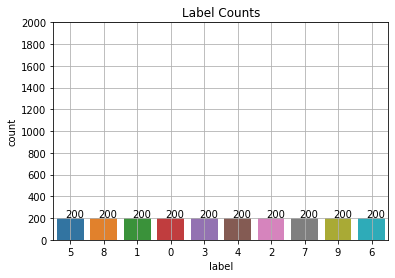

In [ ]:
# Count of Labels.
total = len(df_audio)
print(Counter(df_audio['label']))
ax = sns.countplot(df_audio['label'])
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.grid(True)
plt.title("Label Counts")
plt.show()

From above all labels are equally numbered.

<pre><font size=4>Train and Validation split</font></pre>

In [ ]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
X = df_audio['path']
Y = df_audio['label'].astype("int32")
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 45)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400,), (600,), (1400,), (600,))

<font size=4>Grader function 3 </font>

In [ ]:
def grader_split():
    flag_len = (len(X_train)==1400) and (len(X_test)==600) and (len(y_train)==1400) and (len(y_test)==600)
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain)==10) and (all([i==140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest)==10) and (all([i==60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag
grader_split()

True

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [ ]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [ ]:
# Using Parallel jobs to get the samples and duration for train and test.
a = Parallel(n_jobs=-1, verbose = 1)(delayed(load_wav)(train) for train in X_train) 
b = Parallel(n_jobs=-1, verbose = 1)(delayed(load_wav)(test) for test in X_test) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 1036 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1386 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.0min finished


In [ ]:
Train_samples = []
Train_duration = []
Test_samples = []
Test_duration = []

In [ ]:
a = np.array(a)
Train_samples = a[:,0].tolist()
Train_duration = a[:,1].tolist()
a.dtype

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


dtype('O')

In [ ]:
a = np.array(a)
Train_samples = a[:,0].tolist()
Train_duration = a[:,1].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
b = np.array(b)
Test_samples = b[:,0].tolist()
Test_duration = b[:,1].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
len(Train_samples), len(Test_samples)

(1400, 600)

In [ ]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
X_train_processed = pd.DataFrame(list(zip(Train_samples, Train_duration)), columns = ['raw_data', 'duration'])
X_test_processed = pd.DataFrame(list(zip(Test_samples, Test_duration)), columns = ['raw_data', 'duration'])
X_train_processed.shape, X_test_processed.shape

((1400, 2), (600, 2))

In [ ]:
del a
del b

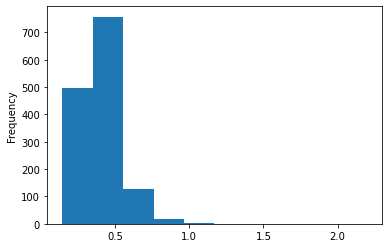

In [ ]:
# Train Duration.
X_train_processed['duration'].plot.hist()

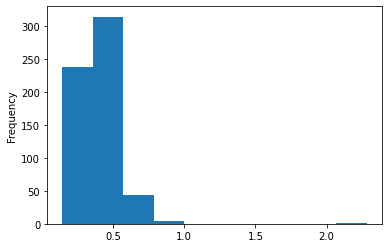

In [ ]:
# Test Duration.
X_test_processed['duration'].plot.hist()

In [ ]:
# Print 0 to 100 percentile values with step size of 10 for train data duration.
for i in range(0, 101, 10):
    per = np.percentile(X_train_processed['duration'], i)
    print(i, 'th percentile is ', per)

0 th percentile is  0.1435374149659864
10 th percentile is  0.2632517006802721
20 th percentile is  0.30514285714285716
30 th percentile is  0.3346485260770975
40 th percentile is  0.35863945578231293
50 th percentile is  0.39045351473922907
60 th percentile is  0.4159546485260771
70 th percentile is  0.44731519274376413
80 th percentile is  0.481342403628118
90 th percentile is  0.5617823129251701
100 th percentile is  2.195918367346939


In [ ]:
# Print 90 to 100 percentile values with step size of 1 for train data duration.
for i in range(90, 101):
    per = np.percentile(X_train_processed['duration'], i)
    print(i, 'th percentile is ', per)

90 th percentile is  0.5617823129251701
91 th percentile is  0.5755346938775511
92 th percentile is  0.5859174603174603
93 th percentile is  0.6012321995464855
94 th percentile is  0.617911111111111
95 th percentile is  0.6330226757369615
96 th percentile is  0.6447981859410431
97 th percentile is  0.6635891156462584
98 th percentile is  0.6956090702947844
99 th percentile is  0.79601179138322
100 th percentile is  2.195918367346939


<font size=4>Grader function 4 </font>

In [ ]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns==['raw_data', 'duration'])) and (all(X_test_processed.columns==['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape ==(1400, 2)) and (X_test_processed.shape==(600,2))
    return flag_columns and flag_shape
grader_processed()

True

## Updating data suitably for the model.

Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset. 

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is  **0.8 * 22050** = **17640**

Pad with Zero if length of sequence is less than 17640 else Truncate the number. 

Also create a masking vector for train and test. 

Masking vector, value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.


In [ ]:
max_length  = 17640

In [ ]:
## As discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## Save in the X_train_pad_seq, X_test_pad_seq
## Also Create masking vector X_train_mask, X_test_mask
## All the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

In [ ]:
X_train_mask = np.array([np.ones(g.shape[0]) for g in X_train_processed['raw_data'].values])
X_train_mask.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(1400,)

In [ ]:
X_test_mask = np.array([np.ones(g.shape[0]) for g in X_test_processed['raw_data'].values])
X_test_mask.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(600,)

In [ ]:
X_train_mask[-50].shape, X_train_processed['raw_data'].values[-50].shape

((6789,), (6789,))

In [ ]:
X_train_pad_seq = pad_sequences(X_train_processed['raw_data'], maxlen=max_length, padding='post', dtype = np.float32, truncating='post')
X_train_mask = pad_sequences(X_train_mask, maxlen=max_length, padding='post', dtype = bool, truncating='post')

In [ ]:
X_test_pad_seq = pad_sequences(X_test_processed['raw_data'], maxlen=max_length, padding='post', dtype = np.float32, truncating='post')
X_test_mask = pad_sequences(X_test_mask, maxlen=max_length, padding='post', dtype = bool, truncating='post')

In [ ]:
X_test_mask

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

<font size=4>Grader function 5 </font>

In [ ]:
def grader_padoutput():
    flag_padshape = (X_train_pad_seq.shape==(1400, 17640)) and (X_test_pad_seq.shape==(600, 17640)) and (y_train.shape==(1400,))
    flag_maskshape = (X_train_mask.shape==(1400, 17640)) and (X_test_mask.shape==(600, 17640)) and (y_test.shape==(600,))
    flag_dtype = (X_train_mask.dtype==bool) and (X_test_mask.dtype==bool)
    return flag_padshape and flag_maskshape and flag_dtype
grader_padoutput()

True

In [ ]:
# Changing the dimension.
X_T_pad = tf.expand_dims(X_train_pad_seq, axis = 2)
X_T_pad.shape, X_T_pad[0].shape

(TensorShape([1400, 17640, 1]), TensorShape([17640, 1]))

In [ ]:
X_Te_pad = tf.expand_dims(X_test_pad_seq, axis = 2)
X_Te_pad.shape, X_Te_pad[0].shape

(TensorShape([600, 17640, 1]), TensorShape([17640, 1]))

In [ ]:
Train = [X_T_pad, X_train_mask]
Val = [X_Te_pad, X_test_mask]

In [ ]:
Train_data = (Train, y_train.values)

In [ ]:
Val_data = (Val, y_test.values)

### 1. (Model 1) Giving Raw data directly. 

<pre>
Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). 
3. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
4. make sure that it won't overfit. 
5. You are free to include any regularization
</pre>

In [ ]:
tf.keras.backend.clear_session()
class Metrics(tf.keras.callbacks.Callback):
    
    def __init__(self, x = None, y = None):
        self.training_data = x 
        self.validation_data = y
    
    def on_train_begin(self, logs = {}):
        ## on begin of training, we are creating a instance varible called history
        self.history={'train_f1_score': [], 'val_f1_score': []}

        
    def on_epoch_end(self, epoch, logs = {}):
        ## on end of each epoch, we will get logs and update the self.history dict
        train_predict = self.model.predict(self.training_data[0], batch_size = 50)
        train_bin = np.argmax(train_predict, axis = 1)
        train_targ = self.training_data[1]
        _train_f1 = f1_score(train_targ, train_bin, average = 'micro')
       
         
        val_predict = self.model.predict(self.validation_data[0], batch_size = 50)
        val_bin = np.argmax(val_predict, axis = 1)
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_bin, average = 'micro')
             
        self.history['val_f1_score'].append(_val_f1)
        self.history['train_f1_score'].append(_train_f1)
        
        print(' - train_f1_score : ', _train_f1, ' - val_f1_score : ', _val_f1)
        return

In [ ]:
def changeLearningRate(epoch):
    global initial_learningrate
    epoch = epoch + 1
    if epoch % 5 == 0:
        initial_learningrate *= 0.55
    return initial_learningrate

In [ ]:
import os
save = 'model_save/*.hdf5'
r = glob.glob(save)
for i in r:
    os.remove(i)

In [ ]:
filepath="model_save/model-{epoch:02d}-{val_sparse_categorical_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_sparse_categorical_accuracy',  verbose=1, save_best_only=True, mode='max')
reducelr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.001, patience = 1, verbose = 1, mode = 'min')

lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)
initial_learningrate=0.001

In [ ]:
metrics = Metrics(Train_data, Val_data)

In [ ]:
callbacks = [metrics, checkpoint, reducelr, lrschedule]

In [ ]:
reg = tf.keras.regularizers.L2(l2=0.01)

In [ ]:
input_layer = Input(shape=(17640,1), name = 'input_layer')
input_mask = Input(shape=(17640,), name = 'mask_layer', dtype=bool)
ls = LSTM(units = 128, name = 'LSTM')(input_layer, mask = input_mask)
ls = BatchNormalization()(ls)
dc1 = Dense(512,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed = 30), name = 'FC2')(ls)
dc1 = Dropout(0.35)(dc1)
out = Dense(10,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed = 30), name = 'FC3')(dc1)

In [ ]:
model_raw = Model(inputs = [input_layer,input_mask], outputs = out)

In [ ]:
model_raw.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
mask_layer (InputLayer)         [(None, 17640)]      0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, 128)          66560       input_layer[0][0]                
                                                                 mask_layer[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         LSTM[0][0]                   

In [ ]:
model_raw.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
model_history = model_raw.fit(Train, y_train.values, batch_size = 50, validation_data = (Val, y_test.values), epochs = 50, verbose = 1, callbacks = callbacks)

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
28/28 [==============================] - 24s 749ms/step - loss: 2.3051 - sparse_categorical_accuracy: 0.0821 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.1000
 - train_f1_score :  0.10000000000000002  - val_f1_score :  0.10000000000000002

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.10000, saving model to model_save/model-01-0.1000.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
28/28 [==============================] - 22s 785ms/step - loss: 2.3020 - sparse_categorical_accuracy: 0.0893 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.1050
 - train_f1_score :  0.10499999999999998  - val_f1_score :  0.10499999999999998

Epoch 00002: val_sparse_categorical_accuracy improved from 0.10000 to 0.10500, saving model to model_save/model-02-0.1050.hdf5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.0000000474974512e-06.
Epoch

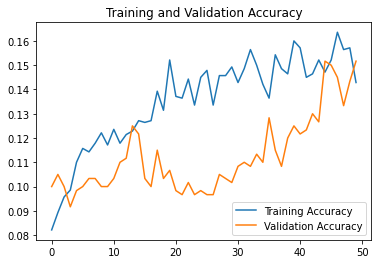

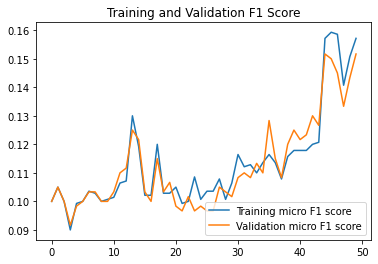

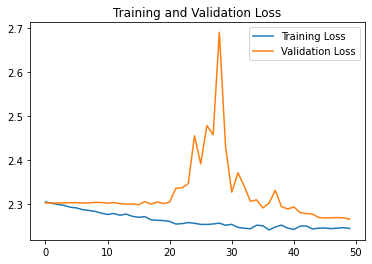

In [ ]:
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

f1 = metrics.history['train_f1_score']
val_f1 = metrics.history['val_f1_score']

epochs_range = range(50)

#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, f1, label='Training micro F1 score')
plt.plot(epochs_range, val_f1, label='Validation micro F1 score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')
plt.show()

#plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model_raw.save('Model_raw_1_0.1517_final.h5')

In [ ]:
model_raw = load_model('/content/model-31-0.1333.hdf5')

In [ ]:
## as discussed above, please write the LSTM
y_pred = model_raw.predict(Val)
y_pred = np.argmax(y_pred, axis = 1)

In [ ]:
print('Classification Report')
print(classification_report(y_test.values, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.07      0.03      0.05        60
           1       0.00      0.00      0.00        60
           2       0.19      0.38      0.25        60
           3       0.16      0.12      0.14        60
           4       0.14      0.02      0.03        60
           5       0.31      0.07      0.11        60
           6       0.14      0.52      0.22        60
           7       0.16      0.10      0.12        60
           8       0.21      0.23      0.22        60
           9       0.08      0.05      0.06        60

    accuracy                           0.15       600
   macro avg       0.15      0.15      0.12       600
weighted avg       0.15      0.15      0.12       600



Text(0.5, 1.0, 'Confusion Matrix')

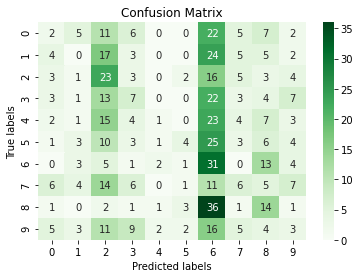

In [ ]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test.values, y_pred), annot=True, ax = ax, fmt='g', cmap='Greens') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 

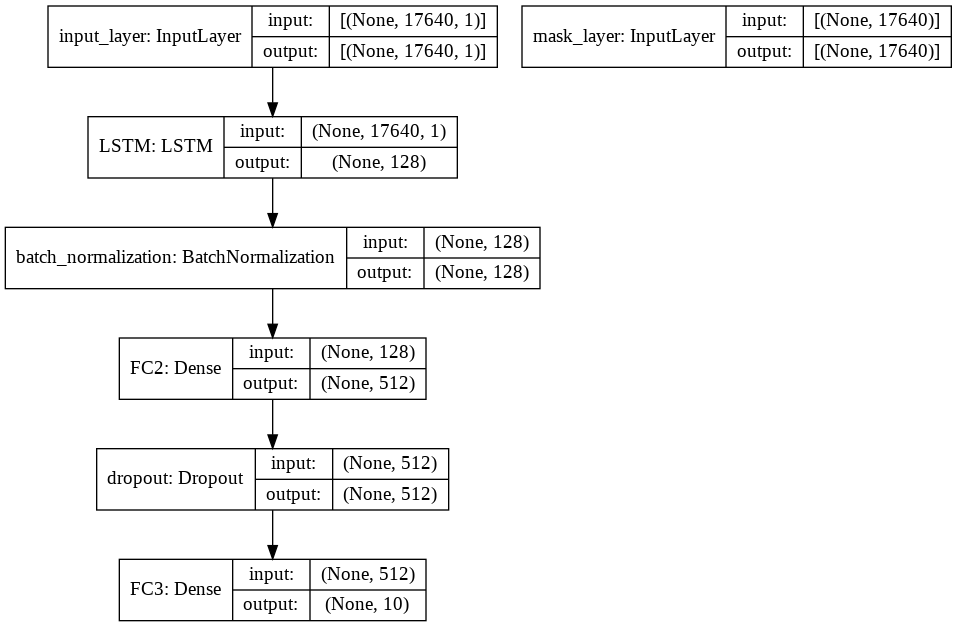

In [ ]:
plot_model(model_raw, show_shapes=True, show_layer_names=True)

### 2. (Model 2) Converting into spectrogram and giving spectrogram data as input.  


<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram
</pre>

In [ ]:
# Function to convert raw padded audio signal into spectogram.
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

Use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.

Save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)

In [ ]:
X_train_spectrogram = []
for j in X_train_pad_seq:
    l = convert_to_spectrogram(j)
    X_train_spectrogram.append(l)
X_train_spectrogram = np.array(X_train_spectrogram) 

In [ ]:
X_test_spectrogram = []
for j in X_test_pad_seq:
    l = convert_to_spectrogram(j)
    X_test_spectrogram.append(l)
X_test_spectrogram = np.array(X_test_spectrogram)

<Figure size 432x288 with 0 Axes>

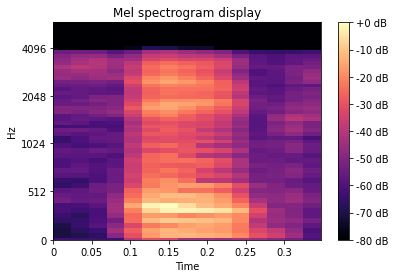

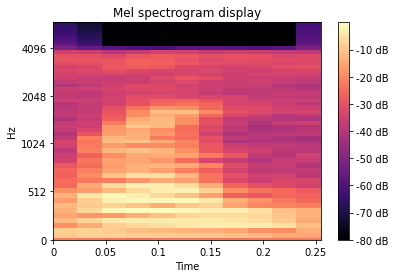

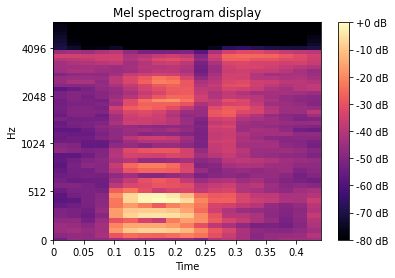

In [ ]:
plt.subplots_adjust(wspace=1, hspace=1)
for i in range(0,3):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(convert_to_spectrogram(X_train_processed['raw_data'][i]), y_axis='mel', x_axis='time', ax=ax)
    ax.set(title='Mel spectrogram display')
    ax.set_ylim([0,6000])
    fig.colorbar(img, ax=ax, format="%+2.f dB")

<font size=4>Grader function 6 </font>

In [ ]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(1400,64, 35)) and (X_test_spectrogram.shape == (600, 64, 35))
    return flag_shape
grader_spectrogram()

True

<pre>
Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
5. make sure that it won't overfit. 
6. You are free to include any regularization
</pre>

In [ ]:
tf.keras.backend.clear_session()
reg = tf.keras.regularizers.L2(l2=1.5)

In [ ]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(64,35), name = 'input_layer')
ls = LSTM(units = 128, name = 'LSTM', return_sequences = True)(input_layer)
ad = GlobalAveragePooling1D()(ls)
dc1 = Dense(1024,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed = 30), name = 'FC1')(ad)
dc1 = Dense(256,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed = 30), name = 'FC2')(dc1)
dc1 = BatchNormalization()(dc1)
dc1 = Dropout(0.6899)(dc1)
out = Dense(10,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed = 30), name = 'FC3')(dc1)

In [ ]:
m_spec = Model(inputs = input_layer, outputs = out)

In [ ]:
m_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 35)]          0         
_________________________________________________________________
LSTM (LSTM)                  (None, 64, 128)           83968     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 1024)              132096    
_________________________________________________________________
FC2 (Dense)                  (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [ ]:
save = 'model_spec_save/*.hdf5'
r = glob.glob(save)
for i in r:
    os.remove(i)

In [ ]:
filepath="model_spec_save/model-{epoch:02d}-{val_sparse_categorical_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_sparse_categorical_accuracy',  verbose=1, save_best_only=True, mode='max')
reducelr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.055, patience = 1, verbose = 1, mode = 'min')

lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)
initial_learningrate=0.001

In [ ]:
Train_data_spec = [X_train_spectrogram, y_train.values]
Test_data_spec = [X_test_spectrogram, y_test.values]

In [ ]:
metrics = Metrics(Train_data_spec, Test_data_spec)

In [ ]:
callbacks = [metrics, checkpoint, reducelr, lrschedule]

In [ ]:
m_spec.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
tf.keras.backend.clear_session()
model_spec_history = m_spec.fit(X_train_spectrogram, y_train.values, batch_size =50, validation_data = (X_test_spectrogram, y_test.values), epochs=50, verbose=1, callbacks=callbacks)

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
28/28 [==============================] - 2s 23ms/step - loss: 2.7975 - sparse_categorical_accuracy: 0.2129 - val_loss: 2.6811 - val_sparse_categorical_accuracy: 0.1583
 - train_f1_score :  0.16857142857142857  - val_f1_score :  0.15833333333333333

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.15833, saving model to model_spec_save/model-01-0.1583.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
28/28 [==============================] - 0s 10ms/step - loss: 2.0661 - sparse_categorical_accuracy: 0.3643 - val_loss: 2.3309 - val_sparse_categorical_accuracy: 0.3250
 - train_f1_score :  0.32571428571428573  - val_f1_score :  0.325

Epoch 00002: val_sparse_categorical_accuracy improved from 0.15833 to 0.32500, saving model to model_spec_save/model-02-0.3250.hdf5
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
28/28 [========

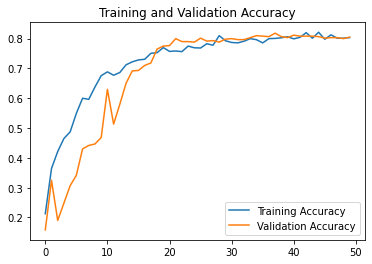

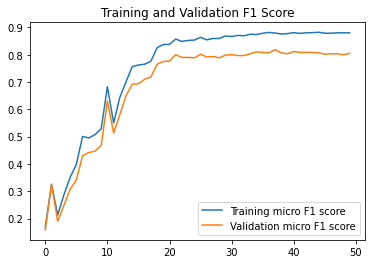

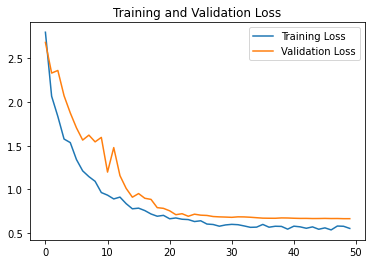

In [ ]:
acc = model_spec_history.history['sparse_categorical_accuracy']
val_acc = model_spec_history.history['val_sparse_categorical_accuracy']

loss = model_spec_history.history['loss']
val_loss = model_spec_history.history['val_loss']

f1 = metrics.history['train_f1_score']
val_f1 = metrics.history['val_f1_score']

epochs_range = range(50)

#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, f1, label='Training micro F1 score')
plt.plot(epochs_range, val_f1, label='Validation micro F1 score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')
plt.show()

#plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
## as discussed above, please write the LSTM
y_pred = m_spec.predict(X_test_spectrogram)
y_pred = np.argmax(y_pred, axis = 1)

In [ ]:
print('Classification Report')
print(classification_report(y_test.values, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        60
           1       0.85      0.87      0.86        60
           2       0.84      0.82      0.83        60
           3       0.68      0.67      0.67        60
           4       0.87      0.90      0.89        60
           5       0.89      0.78      0.83        60
           6       0.70      0.78      0.74        60
           7       0.70      0.78      0.74        60
           8       0.81      0.72      0.76        60
           9       0.85      0.78      0.82        60

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600



Text(0.5, 1.0, 'Confusion Matrix')

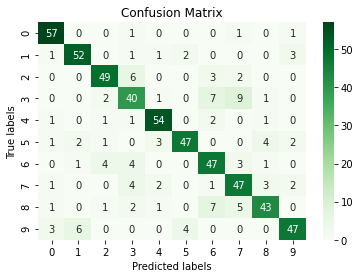

In [ ]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test.values, y_pred), annot=True, ax = ax, fmt='g', cmap='Greens') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 

In [ ]:
m_spec.save('Model_Spect_1_0.805_final.h5')

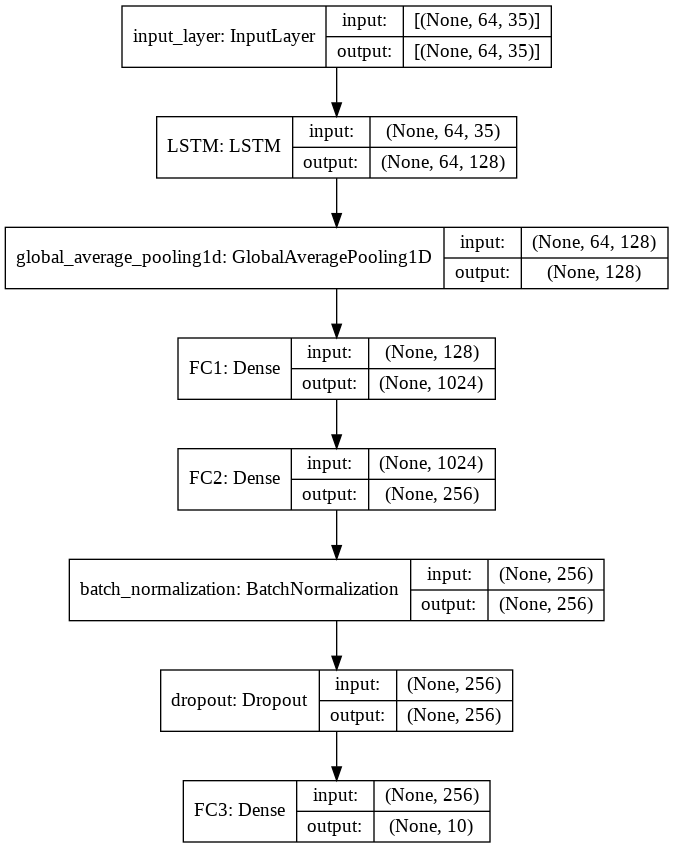

In [ ]:
m_spec = load_model('/content/Model_Spect_1_0.805_final.h5')
plot_model(m_spec, show_shapes=True, show_layer_names=True)

# Data Augmentation  


<pre>
Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

In [ ]:
## generating augmented data. 
def generate_augmented_data(file_path, label):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    augmented_data.append(samples)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data, np.full(len(augmented_data), label)

In [ ]:
Y = df_audio['label'].astype("int32")

In [ ]:
temp_path, temp_lab = df_audio.iloc[1].path, Y.iloc[1]
aug_temp1,auj= generate_augmented_data(temp_path, temp_lab)
len(aug_temp1)

10

As discussed above, for one data point, we will get 9 augmented data points and original point.  
We have 2000 data points(train plus test) so, after augmentation we will get 20000 ( train - 14000, test - 6000). 

do the above steps i.e training with raw data and spectrogram data with augmentation.

In [ ]:
a = Parallel(n_jobs=-1, verbose = 1)(delayed(generate_augmented_data)(i, j) for i, j in zip(df_audio.path,Y.values)) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  8.2min finished


In [ ]:
a = np.array(a)
New_samples = a[:,0].ravel()
New_labels = a[:,1].astype('int32').ravel()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
len(New_samples), len(New_labels)

(20000, 20000)

In [ ]:
# Shuffling the above dataset.
New_samples, New_labels = shuffle(New_samples, New_labels, random_state=33)#don't change the random state

In [ ]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
X_train, X_test, y_train, y_test = train_test_split(New_samples, New_labels, test_size = 0.3, stratify = New_labels, random_state = 45)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14000,), (6000,), (14000,), (6000,))

In [ ]:
X_train_mask = np.array([np.ones(g.shape[0]) for g in X_train])
X_train_mask.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(14000,)

In [ ]:
X_test_mask = np.array([np.ones(g.shape[0]) for g in X_test])
X_test_mask.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(6000,)

In [ ]:
max_length  = 17640
X_train_mask[-50].shape, X_train[-50].shape

((10232,), (10232,))

In [ ]:
X_train_pad_seq = pad_sequences(X_train, maxlen=max_length, padding='post', dtype = np.float32, truncating='post')
X_train_mask = pad_sequences(X_train_mask, maxlen=max_length, padding='post', dtype = bool, truncating='post')

In [ ]:
X_test_pad_seq = pad_sequences(X_test, maxlen=max_length, padding='post', dtype = np.float32, truncating='post')
X_test_mask = pad_sequences(X_test_mask, maxlen=max_length, padding='post', dtype = bool, truncating='post')

In [ ]:
X_test_mask

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [ ]:
X_T_pad = tf.expand_dims(X_train_pad_seq, axis = 2)
X_T_pad.shape, X_T_pad[0].shape

(TensorShape([14000, 17640, 1]), TensorShape([17640, 1]))

In [ ]:
X_Te_pad = tf.expand_dims(X_test_pad_seq, axis = 2)
X_Te_pad.shape, X_Te_pad[0].shape

(TensorShape([6000, 17640, 1]), TensorShape([17640, 1]))

In [ ]:
td1 = tf.data.Dataset.from_tensor_slices((X_T_pad, X_train_mask))
td2 = tf.data.Dataset.from_tensor_slices((y_train))
td = tf.data.Dataset.zip((td1, td2))

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100
train_dataset = td.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
td1 = tf.data.Dataset.from_tensor_slices((X_Te_pad, X_test_mask))
td2 = tf.data.Dataset.from_tensor_slices((y_test))
td = tf.data.Dataset.zip((td1, td2))

In [ ]:
test_dataset = td.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
Train = [X_T_pad, X_train_mask]
Val = [X_Te_pad, X_test_mask]

In [ ]:
Train_data = (Train, y_train)

In [ ]:
Val_data = (Val, y_test)

In [ ]:
del a

### 1. (Model 3) Giving Raw data directly.

In [ ]:
tf.keras.backend.clear_session()
class Metrics(tf.keras.callbacks.Callback):
    
    def __init__(self, x = None, y = None):
        self.training_data = x 
        self.validation_data = y
    
    def on_train_begin(self, logs = {}):
        ## on begin of training, we are creating a instance varible called history
        self.history={'train_f1_score': [], 'val_f1_score': []}

        
    def on_epoch_end(self, epoch, logs = {}):
        ## on end of each epoch, we will get logs and update the self.history dict
        train_predict = self.model.predict(self.training_data[0], batch_size = 128)
        train_bin = np.argmax(train_predict, axis = 1)
        train_targ = self.training_data[1]
        _train_f1 = f1_score(train_targ, train_bin, average = 'micro')
        
         
        val_predict = self.model.predict(self.validation_data[0], batch_size = 128)
        val_bin = np.argmax(val_predict, axis = 1)
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_bin, average = 'micro')
             
        self.history['val_f1_score'].append(_val_f1)
        self.history['train_f1_score'].append(_train_f1)
        
        print(' - train_f1_score : ', _train_f1, ' - val_f1_score : ', _val_f1)
        return

In [ ]:
def changeLearningRate(epoch):
    global initial_learningrate
    epoch = epoch + 1
    if epoch % 5 == 0:
        initial_learningrate *= 0.55
    return initial_learningrate

In [ ]:
import os
save = 'model_aug_raw_save/*.hdf5'
r = glob.glob(save)
for i in r:
    os.remove(i)

In [ ]:
filepath="model_aug_raw_save/model-{epoch:02d}-{val_sparse_categorical_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_sparse_categorical_accuracy',  verbose=1, save_best_only=True, mode='max')
reducelr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.001, patience = 1, verbose = 1, mode = 'min')

lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)
initial_learningrate=0.001

In [ ]:
metrics = Metrics(Train_data, Val_data)

In [ ]:
callbacks = [metrics, checkpoint, reducelr, lrschedule]

In [ ]:
reg = tf.keras.regularizers.L2(l2=0.01)

In [ ]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(17640,1), name = 'input_layer')
input_mask = Input(shape=(17640,), name = 'mask_layer', dtype=bool)
ls = LSTM(units = 128, name = 'LSTM')(input_layer, mask = input_mask)
ls = BatchNormalization()(ls)
dc1 = Dense(512,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed = 30), name = 'FC2')(ls)
dc1 = Dropout(0.35)(dc1)
out = Dense(10,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed = 30), name = 'FC3')(dc1)

In [ ]:
model_aug_raw = Model(inputs = [input_layer,input_mask], outputs = out)

In [ ]:
model_aug_raw.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
mask_layer (InputLayer)         [(None, 17640)]      0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, 128)          66560       input_layer[0][0]                
                                                                 mask_layer[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         LSTM[0][0]                   

In [ ]:
model_aug_raw.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
train_steps = X_train.shape[0]//100
valid_steps = X_test.shape[0]//100
train_steps

140

In [ ]:
model_history = model_aug_raw.fit(train_dataset, validation_data = test_dataset, epochs = 50, verbose = 1, callbacks = callbacks)

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
110/110 [==============================] - 122s 1s/step - loss: 2.2996 - sparse_categorical_accuracy: 0.1069 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.1020
 - train_f1_score :  0.10471428571428572  - val_f1_score :  0.102

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.10200, saving model to model_aug_raw_save/model-01-0.1020.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
110/110 [==============================] - 112s 1s/step - loss: 2.2935 - sparse_categorical_accuracy: 0.1196 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1037
 - train_f1_score :  0.10735714285714287  - val_f1_score :  0.10366666666666667

Epoch 00002: val_sparse_categorical_accuracy improved from 0.10200 to 0.10367, saving model to model_aug_raw_save/model-02-0.1037.hdf5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.0000000474974512e-06.
Epo

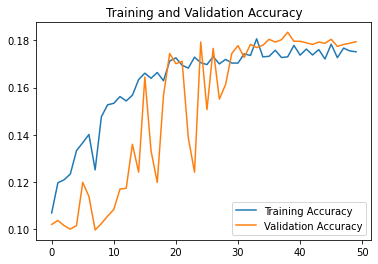

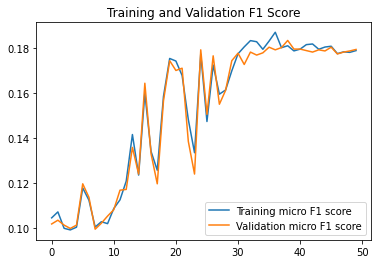

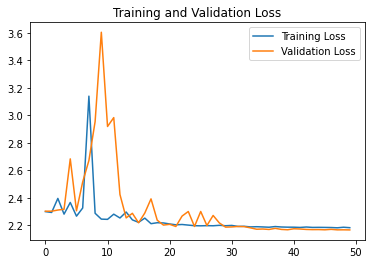

In [ ]:
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

f1 = metrics.history['train_f1_score']
val_f1 = metrics.history['val_f1_score']

epochs_range = range(50)

#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, f1, label='Training micro F1 score')
plt.plot(epochs_range, val_f1, label='Validation micro F1 score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')
plt.show()

#plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model_aug_raw.save('Model_Aug_raw_2_0.1795_final.h5')

In [ ]:
model_raw = load_model('/content/model-31-0.1333.hdf5')

In [ ]:
y_pred = model_aug_raw.predict(Val)
y_pred = np.argmax(y_pred, axis = 1)

In [ ]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.21      0.14      0.17       600
           1       0.10      0.01      0.03       600
           2       0.16      0.12      0.14       600
           3       0.24      0.23      0.24       600
           4       0.15      0.12      0.13       600
           5       0.13      0.06      0.08       600
           6       0.11      0.09      0.10       600
           7       0.17      0.11      0.13       600
           8       0.19      0.83      0.30       600
           9       0.23      0.09      0.13       600

    accuracy                           0.18      6000
   macro avg       0.17      0.18      0.14      6000
weighted avg       0.17      0.18      0.14      6000



Text(0.5, 1.0, 'Confusion Matrix')

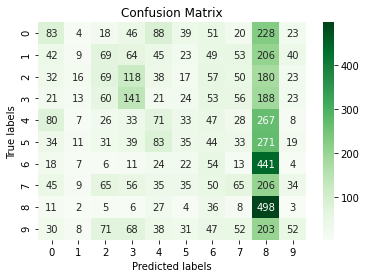

In [ ]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax = ax, fmt='g', cmap='Greens') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 

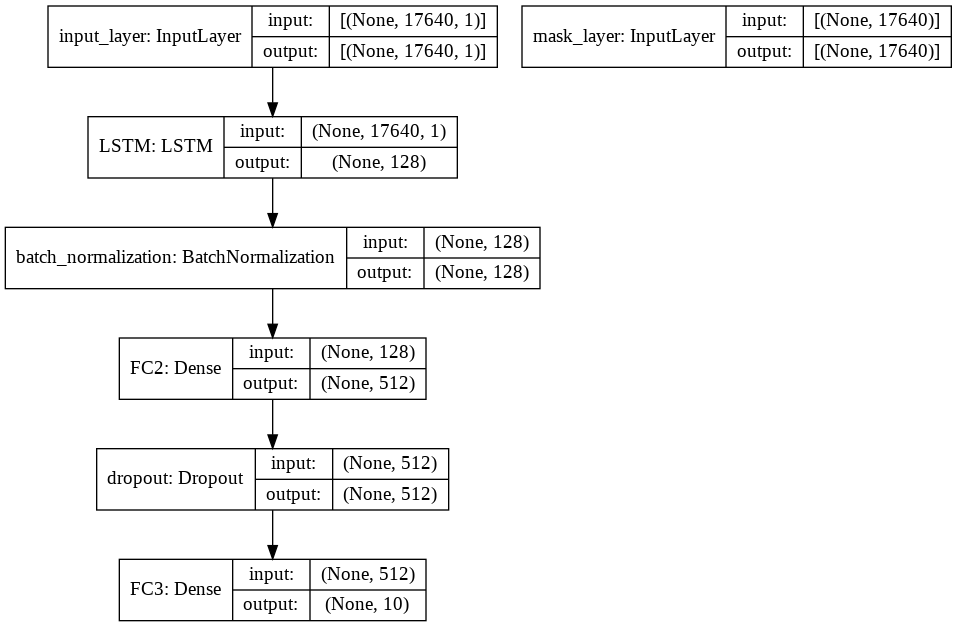

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_aug_raw, show_shapes=True, show_layer_names=True)

### 2. (Model 4) Converting into spectrogram and giving spectrogram data as input.  


<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram
</pre>

In [ ]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

Use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.

Save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)

In [ ]:
X_train_spectrogram = []
for j in X_train_pad_seq:
    l = convert_to_spectrogram(j)
    X_train_spectrogram.append(l)
X_train_spectrogram = np.array(X_train_spectrogram) 

In [ ]:
X_test_spectrogram = []
for j in X_test_pad_seq:
    l = convert_to_spectrogram(j)
    X_test_spectrogram.append(l)
X_test_spectrogram = np.array(X_test_spectrogram)

<font size=4>Grader function 7 </font>

In [ ]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(14000,64, 35)) and (X_test_spectrogram.shape == (6000, 64, 35))
    return flag_shape
grader_spectrogram()

True

In [ ]:
td1 = tf.data.Dataset.from_tensor_slices((X_train_spectrogram, y_train))

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100
train_spec_dataset = td1.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
td1 = tf.data.Dataset.from_tensor_slices((X_test_spectrogram, y_test))

In [ ]:
test_spec_dataset = td1.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

<pre>
Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
5. make sure that it won't overfit. 
6. You are free to include any regularization
</pre>

In [ ]:
reg = tf.keras.regularizers.L2(l2=1.5)

In [ ]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(64,35), name = 'input_layer')
ls = LSTM(units = 128, name = 'LSTM', return_sequences = True)(input_layer)
ad = GlobalAveragePooling1D()(ls)
dc1 = Dense(1024,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed = 30), name = 'FC1')(ad)
dc1 = Dense(256,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed = 30), name = 'FC2')(dc1)
dc1 = BatchNormalization()(dc1)
dc1 = Dropout(0.6599)(dc1)
out = Dense(10,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed = 30), name = 'FC3')(dc1)

In [ ]:
m_aug_spec = Model(inputs = input_layer, outputs = out)

In [ ]:
m_aug_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 35)]          0         
_________________________________________________________________
LSTM (LSTM)                  (None, 64, 128)           83968     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 1024)              132096    
_________________________________________________________________
FC2 (Dense)                  (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [ ]:
save = 'model_aug_spec_save/*.hdf5'
r = glob.glob(save)
for i in r:
    os.remove(i)

In [ ]:
filepath="model_aug_spec_save/model-{epoch:02d}-{val_sparse_categorical_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_sparse_categorical_accuracy',  verbose=1, save_best_only=True, mode='max')
reducelr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.055, patience = 1, verbose = 1, mode = 'min')

lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)
initial_learningrate=0.001

In [ ]:
Train_data_spec = [X_train_spectrogram, y_train]
Test_data_spec = [X_test_spectrogram, y_test]

In [ ]:
metrics = Metrics(Train_data_spec, Test_data_spec)

In [ ]:
callbacks = [metrics, checkpoint, reducelr, lrschedule]

In [ ]:
m_aug_spec.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
model_spec_history = m_aug_spec.fit(train_spec_dataset, validation_data = test_spec_dataset, epochs=50, verbose=1, callbacks=callbacks)

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
110/110 [==============================] - 3s 13ms/step - loss: 1.9682 - sparse_categorical_accuracy: 0.3611 - val_loss: 2.2989 - val_sparse_categorical_accuracy: 0.2170
 - train_f1_score :  0.22314285714285714  - val_f1_score :  0.217

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.21700, saving model to model_aug_spec_save/model-01-0.2170.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
110/110 [==============================] - 1s 10ms/step - loss: 1.3241 - sparse_categorical_accuracy: 0.5379 - val_loss: 1.7650 - val_sparse_categorical_accuracy: 0.3887
 - train_f1_score :  0.4025  - val_f1_score :  0.38866666666666666

Epoch 00002: val_sparse_categorical_accuracy improved from 0.21700 to 0.38867, saving model to model_aug_spec_save/model-02-0.3887.hdf5
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
110/110 [=======

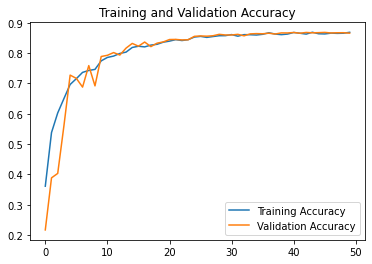

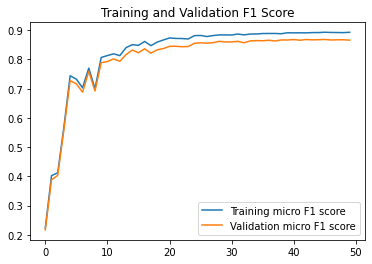

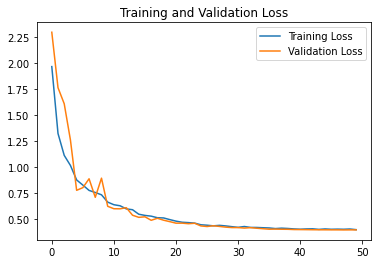

In [ ]:
acc = model_spec_history.history['sparse_categorical_accuracy']
val_acc = model_spec_history.history['val_sparse_categorical_accuracy']

loss = model_spec_history.history['loss']
val_loss = model_spec_history.history['val_loss']

f1 = metrics.history['train_f1_score']
val_f1 = metrics.history['val_f1_score']

epochs_range = range(50)

#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, f1, label='Training micro F1 score')
plt.plot(epochs_range, val_f1, label='Validation micro F1 score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')
plt.show()

#plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
## as discussed above, please write the LSTM
y_pred = m_aug_spec.predict(X_test_spectrogram)
y_pred = np.argmax(y_pred, axis = 1)
#p = p.round()

In [ ]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       600
           1       0.91      0.88      0.90       600
           2       0.82      0.84      0.83       600
           3       0.75      0.71      0.73       600
           4       0.96      0.98      0.97       600
           5       0.90      0.89      0.89       600
           6       0.80      0.78      0.79       600
           7       0.83      0.86      0.84       600
           8       0.83      0.85      0.84       600
           9       0.90      0.92      0.91       600

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



Text(0.5, 1.0, 'Confusion Matrix')

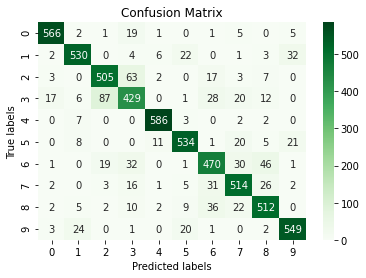

In [ ]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax = ax, fmt='g', cmap='Greens') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 

In [ ]:
m_aug_spec.save('Model_Aug_Spect_2_0.805_final.h5')

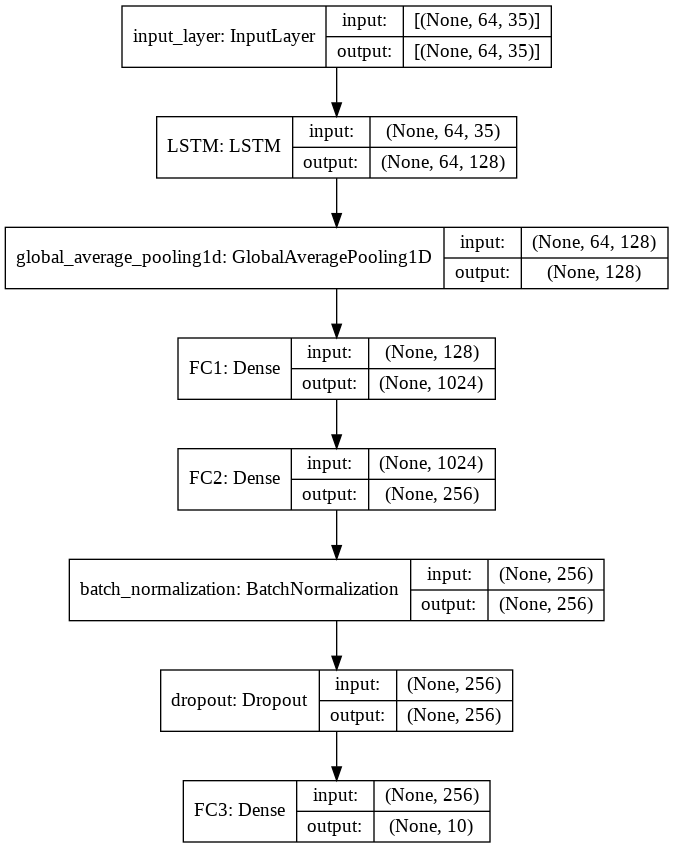

In [ ]:
plot_model(m_aug_spec, show_shapes=True, show_layer_names=True)

# Summary

| Data | Model | Test_F1_Score |
|---- |---- | ----- |
|Original - Raw Data|Model - 1| 0.1517 |
|Original - Spectogram|Model - 2 | 0.805|
|Augmented - Raw Data|Model - 3 | 0.1795|
|Augmented - Spectogram|Model - 4 | 0.8658|

> From the above, it is seen that **Spectogram** data shows good F1-Score than using it as raw data.

> Data Augmentation on original data improvise the F1-Score than the given original data.



